In [1]:
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
import numpy as np
import metrics
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from model import *    
import os

In [2]:
def gene_to_list(gene, size = [236,288,280,336]):
    size = [size[0], size[0] + size[1], size[0]+size[1]+size[2], size[0]+size[1]+size[2]+size[3]]
    return [0,gene[:size[0]], gene[size[0]:size[1]], gene[size[1]:size[2]], gene[size[2]:]]

In [3]:
best_cost = []
pools = []
for i in range(100):
    cost = np.load('results/genetic_algorithm/gene_cost_'+str(i)+'.npy')
    pool = np.load('results/genetic_algorithm/gene_pool_'+str(i)+'.npy')
    best_cost.append(cost.min())
    pools.append(pool)
import matplotlib.pyplot as plt

# plt.plot(best_cost)
# plt.show()

list_queries = gene_to_list(pools[1][0])
fold = 1
directory = '/home/mimorris/Datasets/ili_data/dataset_forecasting_lag28/us_smoothed_14/fold' + str(fold) + '/google-train'
x_train = pd.read_csv(directory, index_col=0, parse_dates=True)

x_train.columns[list_queries[1][:-1].astype(bool)]
x_train.columns[(-1*list_queries[1][:-1]).astype(bool)]

Index(['flu last', 'how to treat the flu', 'a flu', 'flu in pregnancy',
       'flu fever', 'cold flu', 'flu pregnant', 'toddler flu',
       'flu shot ingredients', 'cdc flu',
       ...
       'flu symptoms in adults', 'stomach flu symptoms', 'cure for flu',
       'cold and flu medicine', 'early flu symptoms', 'flu antibiotics',
       'flu quiz', 'cold vs flu symptoms', 'flu spray', 'having the flu'],
      dtype='object', length=118)

In [4]:
x_train

,cold and flu remedies,how long is the flu contagious,flu last,flu strains,how to treat the flu,sick with flu,flu cough,a flu,flu like,flu in pregnancy,...,cold and flu medicine,flu in adults,effects of swine flu,early flu symptoms,flu antibiotics,flu quiz,swine flu symptoms in children,cold vs flu symptoms,flu spray,having the flu
2005-08-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.590670,19.915868,0.000000,...,5.387416,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.393895
2005-09-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.930325,48.456912,0.000000,...,4.489513,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,21.441084
2005-09-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.281954,46.934730,0.000000,...,3.848154,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,12.325868
2005-09-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.114141,30.121526,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.648724
2005-09-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.098531,19.578999,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.236543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-05,0.755169,2.509811,12.925725,4.301582,4.896747,7.633392,9.063658,63.533250,34.991698,1.081124,...,5.958628,6.221368,0.0,5.918912,3.958106,3.945492,2.127421,3.877024,0.0,5.955601
2014-08-06,4.692719,3.447280,14.198312,4.237776,4.809087,6.992603,9.624326,67.013208,35.214938,3.949697,...,5.037080,3.957961,0.0,12.243606,6.434395,2.234453,1.063711,2.292875,0.0,5.223930
2014-08-07,5.810678,4.711850,15.178392,2.810818,3.005018,6.699492,11.192073,67.325631,36.642014,5.472766,...,8.197857,2.818356,0.0,14.147708,3.561071,1.630389,0.709140,3.973697,0.0,5.638802
2014-08-08,3.105969,2.784852,11.982151,3.877591,4.665100,9.480660,8.537768,68.154511,38.083267,5.453950,...,6.470095,3.564061,0.0,10.040709,4.575183,2.786480,0.531855,3.941554,0.0,5.378117


In [5]:
class data_builder:
    def __init__(self, root, fold, gamma,country='eng', validation_size = 0):
        self.validation_size = validation_size
        self.directory = root + 'dataset_forecasting_lag28/'+country+'_smoothed_' + str(gamma) + '/fold' + str(fold) + '/'

    def load_ili_data(self, path):
        ili_data = pd.read_csv(path, header=None, names=['ili'], index_col=0, parse_dates=True)
        return ili_data

    def load_google_data(self, path):
        google_data = pd.read_csv(path, index_col=0, parse_dates=True)
        return google_data

    def window(self, data):
        windowed = []
        for i in range(1+data.shape[0] - 28):
            windowed.append(data[i:i + 28])
        windowed = np.asarray(windowed)
        return windowed

    def build(self, normalize_all=False):
            x_train = self.load_google_data(self.directory + 'google-train')
            x_test = self.load_google_data(self.directory + 'google-test')

            x_train['ili'] = self.load_ili_data(self.directory + 'ili-train')['ili'].values
            x_test['ili'] = self.load_ili_data(self.directory + 'ili-test')['ili'].values

            y_train = self.load_ili_data(self.directory + 'y-train')
            y_test = self.load_ili_data(self.directory + 'y-test')

            self.x_scaler = MinMaxScaler()
            self.x_scaler.fit(x_train)
            
            self.y_scaler = MinMaxScaler()
            self.y_scaler.fit(y_train)
            
            x_train = self.x_scaler.transform(x_train)
            x_test = self.x_scaler.transform(x_test)
            
            y_train = self.y_scaler.transform(y_train)
            y_test = self.y_scaler.transform(y_test)
            
            x_train = self.window(x_train)
            x_test = self.window(x_test)

            assert (x_train.shape[0] == y_train.shape[0])
            assert (x_test.shape[0] == y_test.shape[0])

            y_test = y_test
            y_train = y_train

            self.x_train = x_train[:-self.validation_size].astype('float32')
            self.x_val = x_train[-self.validation_size:].astype('float32')
            
            self.y_train = y_train[:-self.validation_size].astype('float32')
            self.y_val = y_train[-self.validation_size:].astype('float32')
            
            self.x_test = x_test.astype('float32')
            self.y_test = y_test.astype('float32')

In [6]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [7]:
def cost(gene, data):
    gene = gene_to_list(gene)
    train_losses = 0
    val_losses = 0
    
    for fold_num in range(1,5):
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005), loss='mse')

        early_stopping_callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0, patience=20, verbose=0,
            mode='auto', baseline=None, restore_best_weights=True
        )

        x_train = data[fold_num].x_train[:,:,gene[fold_num].astype('bool')]
        y_train = data[fold_num].y_train
        if np.random.rand() > 0.5:
            x_test = data[fold_num].x_test[:,:,gene[fold_num].astype('bool')]
            x_val = data[fold_num].x_val[:,:,gene[fold_num].astype('bool')]
            y_test = data[fold_num].y_test
            y_val = data[fold_num].y_val
  
        else:
            x_val = data[fold_num].x_test[:,:,gene[fold_num].astype('bool')]
            x_test = data[fold_num].x_val[:,:,gene[fold_num].astype('bool')]
            y_val = data[fold_num].y_test
            y_test = data[fold_num].y_val
        

        model.fit(x_train, data[fold_num].y_train, 
                  validation_data=(x_val,y_val),
                  epochs=args.Epochs,
                  verbose=0,
                  callbacks=[early_stopping_callback])
        
        train_losses = train_losses + model.history.history['loss'][-1] 
        val_losses = val_losses + model.history.history['val_loss'][-1] 
        tf.keras.backend.clear_session()
        
    return train_losses + val_losses

In [8]:
def cost2(gene, true):
    return np.sqrt(np.mean(np.square(true-gene)))

def order(pool, data):
    costs = np.zeros((num_genes,1))
    for i in range(num_genes):
        costs[i] = cost(pool[i], data)
    
    return np.argsort(costs, 0).squeeze(), np.sort(costs, 0).squeeze()

In [9]:
def breed(gene1, gene2, num_offspring=2):
    ls = []
    for i in range(num_offspring):
        split = np.random.randint(0,gene_size)
        ls.append(np.concatenate([gene1[:split], gene2[split:]], 0))
    return np.asarray(ls)

In [10]:
def retard(pool, chance=0.01):
    for i in range(num_genes):
        for j in range(gene_size):
            if np.random.rand()<chance:
                pool[i,j] = np.random.randint(0,2)
                
    return pool

In [11]:
def kill(pool, percentage = 0.2):
    num = int(num_genes*percentage)
    pool[-num:] = np.random.randint(0,2,pool[-num:].shape)
    return pool

In [12]:
def breed_all(pool):
    ls = [pool[:2,:]]
    for i in range(int(num_genes/2)):
        ls.append(breed(pool[i], pool[i+1]))
    ls = np.vstack(ls)
    
    return ls[:-1]

In [13]:
d_shapes = [236,288,280,336]
gene_size = 236+288+280+336
num_genes = 50
epochs = 100
cost_hist = []
true = np.random.randint(0, 2,gene_size)
pool = np.random.randint(0, 2,(num_genes,gene_size))

In [14]:
data = ['']
args = Namespace(Batch_Size=64, Epochs=200, Gamma=14, country='us')
for fold_num in range(1,5):
        data.append(data_builder(root="/home/mimorris/Datasets/ili_data/", 
                            fold=fold_num, 
                            gamma=args.Gamma, 
                            country = args.country,
                            validation_size=365))
        data[fold_num].build()

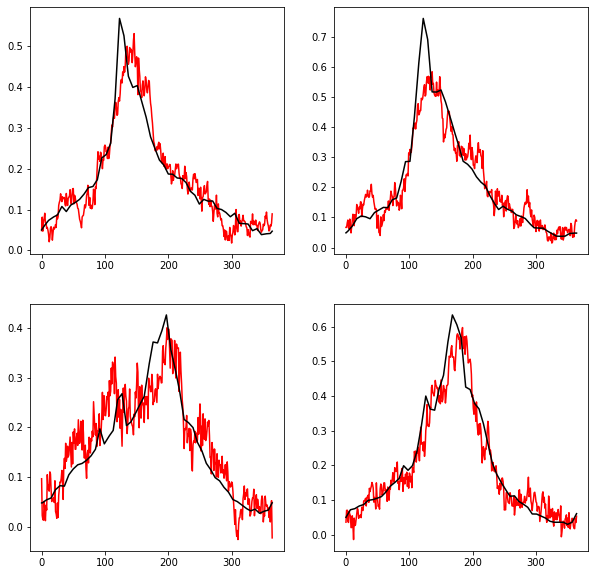

In [15]:
pool = np.load('results/genetic_algorithm/gene_pool_'+str(99)+'.npy')

gene = gene_to_list(pool[0])
train_losses = 0
val_losses = 0

plt.figure(figsize=(10,10))
for fold_num in range(1,5):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005), loss='mse')

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=20, verbose=0,
        mode='auto', baseline=None, restore_best_weights=True
    )

    x_train = data[fold_num].x_train[:,:,gene[fold_num].astype('bool')]
    x_test = data[fold_num].x_test[:,:,gene[fold_num].astype('bool')]
    x_val = data[fold_num].x_val[:,:,gene[fold_num].astype('bool')]

    y_train = data[fold_num].y_train
    y_test = data[fold_num].y_test
    y_val = data[fold_num].y_val

    model.fit(x_train, data[fold_num].y_train, 
              validation_data=(x_val,y_val),
              epochs=args.Epochs,
              verbose=0,
              callbacks=[early_stopping_callback])

    train_losses = train_losses + model.history.history['loss'][-1] 
    val_losses = val_losses + model.history.history['val_loss'][-1] 
    
    plt.subplot(2,2,fold_num)
    plt.plot(model(x_val), color='red')
    plt.plot(y_val, color='black')

    
    tf.keras.backend.clear_session()
plt.show()


In [16]:
val_losses

0.011484936345368624

In [17]:
val_losses

0.011484936345368624

In [ ]:
for epoch in range(100,500,1):
    ranking, costs = order(pool, data)
    pool = pool[ranking]
    
    np.save('results/genetic_algorithm/gene_pool_'+str(epoch)+'.npy',pool)
    np.save('results/genetic_algorithm/gene_cost_'+str(epoch)+'.npy',costs)
    print(epoch, costs.min())
    
    pool = breed_all(pool)
    pool = retard(pool)
    pool = kill(pool, 0.1)
    cost_hist.append(costs.min())

import matplotlib.pyplot as plt
plt.plot(np.asarray(cost_hist))
plt.show()

print(np.asarray(cost_hist).min())

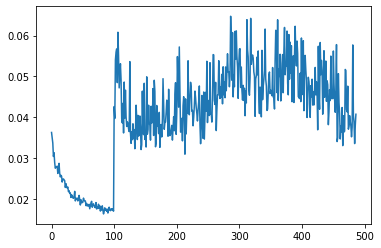

In [6]:
import matplotlib.pyplot as plt
import numpy as np

cost = []
for i in range(487):
    cost.append(np.load('results/genetic_algorithm/gene_cost_'+str(i)+'.npy').mean())

plt.plot(cost)
plt.show()

In [4]:
cost

0.022589281099499203